<a href="https://colab.research.google.com/github/jellyho/AI_Learning_jellyho/blob/main/6_Data_Preprocessing_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

데이터 불러오기

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data')
df.columns = ['Class label', 'Alcohol', 'Malic Acid', 'Ash', 'Alcalinity of Ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df

,Class label,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
173,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
174,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
175,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


데이터 훈련셋과 테스트셋으로 나누기

In [3]:
from sklearn.model_selection import train_test_split as tts
X, y = df.iloc[:, 1:].values, df.iloc[:,0].values
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=0, stratify=y)

최소-최대 변환 x = (x - x_min) / (x_max - x_min) 변수의 값을 0에서 1사이로 맞추는 것

In [18]:
from sklearn.preprocessing import MinMaxScaler as MMS
mms = MMS()
mms.fit(X_train)
X_train_norm = mms.transform(X_train)
X_test_norm = mms.transform(X_test)
X_train_norm

array([[0.51461988, 0.87944664, 0.40522876, ..., 0.12765957, 0.08677686,
        0.31883024],
       [0.6871345 , 0.15612648, 0.65359477, ..., 0.81914894, 0.71487603,
        0.68259629],
       [0.67836257, 0.15019763, 0.65359477, ..., 0.75531915, 0.59504132,
        0.71825963],
       ...,
       [0.64619883, 0.83201581, 0.4248366 , ..., 0.45744681, 0.32231405,
        0.19400856],
       [0.23684211, 0.10869565, 0.15686275, ..., 0.40425532, 0.7231405 ,
        0.02425107],
       [0.47953216, 1.        , 0.28104575, ..., 0.26595745, 0.75619835,
        0.07275321]])

표준화 -> 평균이 0이고 표준편차가 1인 분포로 만드는 것

In [26]:
std = X_train.std(axis=0)
mean = X_train.mean(axis=0)
X_train_std = (X_train - mean) / std
X_test_std = (X_test - mean) / std
X_train_std

array([[ 0.1937094 ,  2.37977151, -0.20420766, ..., -1.5782345 ,
        -1.64200771, -0.08460637],
       [ 0.92207682, -0.70975882,  1.25077192, ...,  1.40544599,
         0.55879351,  1.47960155],
       [ 0.88504119, -0.73508284,  1.25077192, ...,  1.13002933,
         0.1389038 ,  1.63295526],
       ...,
       [ 0.74924387,  2.17717936, -0.08934085, ..., -0.15524842,
        -0.81670726, -0.62134438],
       [-0.97908559, -0.91235098, -1.65918724, ..., -0.3847623 ,
         0.58775142, -1.35130807],
       [ 0.04556687,  2.89469324, -0.93169745, ..., -0.9814984 ,
         0.70358306, -1.14274701]])

만약 훈련세트에서 테스트세트에서보다 성능이 많이 높다면 과대적합의 증거이다. 이럴 때는 더욱 간단한 모델을 만들도록 노력해야 한다.

특성 선택을 통해 차원을 축소시켜 학습 파라미터를 줄여 모델 복잡도를 줄여 더욱 간단한 모델을 만들 수 있다.

1) 규제.

L2 규제는 가중치의 제곱을 줄이는 것, L1규제는 가중치 절댓값을 줄이는 것이다. L1규제는 희소한 특성 벡터를 만들어 대부분의 가중치가 0이 된다. 이 뜻은 관련없는 특성을 무시하는 특성 선택의 기법이 될 수 있음을 의미한다.

사이킷런에서 L1규제를 이용하여 로지스틱 회귀로 학습 시키기.

In [38]:
from sklearn.linear_model import LogisticRegression as LG
lr = LG(solver='liblinear', multi_class='auto', penalty='l1', C=1.0, random_state=46)
lr.fit(X_train_std, y_train)
print(lr.predict(X_test_std[20:25]),y_test[20:25])

[1 3 2 2 2] [1 3 2 2 2]


2)차원축소.

규제가 없는 모델에서 유용. 특성 선택과 특성 추출로 나뉜다. 순차 후진 선택이 대표적인 방법(SBS)

In [46]:
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
  def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
    self.scoring = scoring
    self.estimator = estimator
    self.k_features = k_features
    self.test_size = test_size
    self.random_state = random_state
  
  def fit(self, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

    dim = X_train.shape[1]
    self.indices_ = tuple(range(dim))
    self.subsets_ = [self.indices_]
    score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
    self.scores_ = [score]

    while dim > self.k_features:
      scores = []
      subsets = []

      for p in combinations(self.indices_, r=dim -1):
        score = self._calc_score(X_train, y_train, X_test, y_test, p)
        scores.append(score)
        subsets.append(p)

      best = np.argmax(scores)
      self.indices_ = subsets[best]
      self.subsets_.append(self.indices_)
      dim = dim -1

      self.scores_.append(scores[best])
    self.k_score_ = self.scores_[-1]

    return self

  def transform(self, X):
    return X[:, self.indices_]

  def _calc_score(self, X_train, y_train, X_test, y_test, indices):
    self.estimator.fit(X_train[:, indices], y_train)
    y_pred = self.estimator.predict(X_test[:,indices])
    score = self.scoring(y_test, y_pred)
    return score

차원 축소 효과 시각화

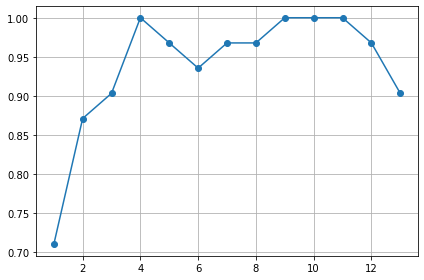

In [48]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as KNC

knn = KNC(n_neighbors=5)

sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.grid()
plt.tight_layout()
plt.show()

그래프를 보면 특성이 작은 것 중에 좋은 성과를 보이는 것은 특성이 4개일 때이다. 이때의 특성 목록을 출력하면 아래와 같다.

In [69]:
k4 = list(sbs.subsets_[len(sbs.subsets_) - 4])
print(df.columns[1:][k4])

Index(['Malic Acid', 'Proanthocyanins', 'Hue', 'Proline'], dtype='object')
